# A short tutorial on USTC-Pickers (<3 min)
* If any question, please feel free to contact me via email: `zhujun2316@mail.ustc.edu.cn`
* Dependencies: Obspy, PyTorch, [SeisBench](https://github.com/seisbench/seisbench)

## Load a model

In [1]:
import seisbench
import seisbench.models as sbm
import os
import glob
import torch
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
from config import (en2cn, model_list)
sample_rate = 50
# 为拾取的目标区域选定合适的picker，如Sichuan（四川）、CSES（实验场）、TP（青藏高原）、China（中国）
location = input('Plase specify a region or province to pick phases, e.g. Beijing. 42 pickers are available in the subfolder "%s"'%os.path.join('USTC-Pickers', 'model_list', 'v0.1'))
if location not in en2cn:
    exit('The region you specified is not available. Plase choose a region or province from below--------\n%s\n-----------------------------------------------------------------------------------------------'%(', '.join(en2cn)))
elif location!='China':
    model_save_path = glob.glob(os.path.join(model_list, '*'+en2cn[location]+'.pt'))[0]
    print('You are using the picker located at %s\n'%model_save_path)
    # 模型初始化
    picker = sbm.PhaseNet(sampling_rate=sample_rate)
    # 加载模型
    picker.load_state_dict(torch.load(model_save_path,
			map_location=device).state_dict())
else:
    print('You are using the China picker, "diting", published by SeisBench')
    picker = sbm.PhaseNet.from_pretrained('diting')
    picker.sampling_rate=sample_rate

You are using the picker located at ../model_list/v0.1/青海省.pt



## Read waveforms

In [2]:
from obspy import read
from config import (sac, mseed)

# Read the 3-component waveforms as input
#sac = sac.replace('Beijing', 'Sichuan')
#mseed = mseed.replace('Beijing', 'Sichuan')
inputfile = mseed
print(inputfile)
stream = read(inputfile)
print(stream)

../test_data/mseed/Beijing*.mseed
3 Trace(s) in Stream:
...BHZ | 2018-07-18T15:24:11.300000Z - 2018-07-18T15:27:11.280000Z | 50.0 Hz, 9000 samples
...BHN | 2018-07-18T15:24:11.300000Z - 2018-07-18T15:27:11.280000Z | 50.0 Hz, 9000 samples
...BHE | 2018-07-18T15:24:11.300000Z - 2018-07-18T15:27:11.280000Z | 50.0 Hz, 9000 samples


## Model response (optional)

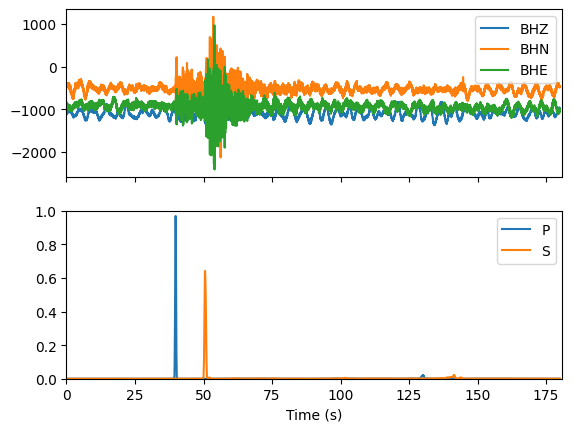

In [3]:
import numpy as np
response = picker.annotate(stream)
# Plot the response
import matplotlib.pyplot as plt

time_diff = response[0].stats.starttime-stream[0].stats.starttime
fig, ax = plt.subplots(2, 1, sharex=True)
t0 = np.arange(stream[0].stats.npts)/sample_rate
t1 = np.arange(response[0].stats.npts)/sample_rate + time_diff
ax[0].plot(t0, np.array([x.data for x in stream]).transpose(), label=[x.stats.channel for x in stream])
ax[1].plot(t1, np.array([x.data for x in response[1:]]).transpose(), label=['P', 'S'])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylim(0, 1)
for j in ax:
    j.legend()
    j.set_xlim(0, t0.max()+1)
plt.show()
plt.close()

## Retrieve the predicted picks

In [4]:
detections = picker.classify(stream, P_threshold=.3, S_threshold=.3) # Both thresholds can be tuned for your target
for x in detections:
    print(x.__dict__)

# store the picks
import pandas as pd
P,S = [],[]
for x in detections:
    if x.phase=='P':
        P.append(x)
    else:
        S.append(x)
p, s = [str(x.peak_time) for x in P], [str(x.peak_time) for x in S]
p_prob, s_prob = [x.peak_value for x in P], [x.peak_value for x in S]
entry = {'fname':[inputfile], 'p':[p], 's':[s], 'p_prob':[p_prob], 's_prob':[s_prob]}
table = pd.DataFrame(entry)
table.to_csv('results/picks_demo.csv', index=False)

{'trace_id': '..', 'start_time': UTCDateTime(2018, 7, 18, 15, 24, 50, 880000), 'end_time': UTCDateTime(2018, 7, 18, 15, 24, 51, 420000), 'peak_time': UTCDateTime(2018, 7, 18, 15, 24, 51, 140000), 'peak_value': 0.96867764, 'phase': 'P'}
{'trace_id': '..', 'start_time': UTCDateTime(2018, 7, 18, 15, 25, 1, 600000), 'end_time': UTCDateTime(2018, 7, 18, 15, 25, 2, 340000), 'peak_time': UTCDateTime(2018, 7, 18, 15, 25, 1, 860000), 'peak_value': 0.64157975, 'phase': 'S'}
